# Proceso de creación del modelo

## Carga de librerías y datasets

In [334]:
from datetime import datetime
import pandas as pd
import numpy as np
import TOOLBOX_1 as t1
import Team_Challenge_ToolBox_II as t2
import funciones as fn 
import new_funtions as nf

from pmdarima import auto_arima
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from math import sqrt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

from concurrent.futures import ThreadPoolExecutor, TimeoutError
import optuna
from joblib import dump

In [258]:
train = pd.read_csv('./data_bike_sharing/train.csv')
test = pd.read_csv('./data_bike_sharing/test.csv')

## Primera aproximación a los datos

#### Descripción de las columnas
**datetime** - hourly date + timestamp  

**season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

**holiday** - whether the day is considered a holiday

**workingday** - whether the day is neither a weekend nor holiday

**weather** - 

    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy

    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

**temp** - temperature in Celsius

**atemp** - "feels like" temperature in Celsius

**humidity** - relative humidity

**windspeed** - wind speed

**casual** - number of non-registered user rentals initiated

**registered** - number of registered user rentals initiated

**count** - number of total rentals

In [259]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [260]:
fn.crea_df_std(train)

,name,type,prio,card,card%,NaN,Unknown,%_NaN,Category
0,datetime,object,3,10886,100.00,0,0,0.0,Categórica
1,season,int64,3,4,0.04,0,0,0.0,Categórica
2,holiday,int64,3,2,0.02,0,0,0.0,Binaria
3,workingday,int64,3,2,0.02,0,0,0.0,Binaria
4,weather,int64,3,4,0.04,0,0,0.0,Categórica
5,temp,float64,3,49,0.45,0,0,0.0,Numérica Discreta
6,atemp,float64,3,60,0.55,0,0,0.0,Numérica Discreta
7,humidity,int64,3,89,0.82,0,0,0.0,Numérica Discreta
8,windspeed,float64,3,28,0.26,0,0,0.0,Numérica Discreta
9,casual,int64,3,309,2.84,0,0,0.0,Numérica Continua


In [261]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


## Revisión de nulos y faltantes

In [262]:
# Establecemos las fechas y horas como índice
train['datetime'] = pd.to_datetime(train['datetime'])
train_dt = train.sort_values("datetime").set_index("datetime").copy()
train_dt.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [263]:
# Comprobaremos que están todas las horas que se suponen que nos dan. De las 00.00 a las 23.00 cada hora y del 0 al 19 de cada mes de los años 2011 y 2012.

total_fechas = 24 * 19 * 12 * 2 

print (len(train_dt))
print(total_fechas)



10886
10944


In [264]:
# Parece que faltan algunas filas. Vamos crear una opción en la que trabajaremos con las horas que faltan añadidas al data set, imputando las temperaturas, humedad y windspeed como la media de la hora siguiente y anterior. Count será 0 así mismo casual y registered. 
# Para determinar las hroas que nos faltan primero, vamso a crear una lista de fechas y horas completa.
date_list = [datetime(year, month, day, hour, 0, 0).strftime('%Y-%m-%d %H:%M:%S')
             for year in range(2011, 2013)
             for month in range(1, 13)
             for day in range(1, 20)
             for hour in range(24)]

index_list = [str(elem) for elem in train_dt.index.tolist()]

diff = []

# Ahora la comparamos con la lista de índices que tenemos y vemos cuales no están. 
for h in date_list:
    if h not in index_list:
        diff.append(h)

diff_datetime = [datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S') for date_str in date_list]

len(diff)

58

In [265]:
# Ya sabemos las filas que nos faltarían y ahora las añadimos al df

train_dt_all = train_dt.reindex(index=train_dt.index.union(diff_datetime)).copy()

con_0 = ['count', 'casual', 'registered']
media = ['temp', 'atemp', 'humidity', 'windspeed']
con_dia = ['season', 'holiday', 'workingday', 'weather']

train_dt_all = train_dt_all.sort_index()

train_dt_all[con_0] = train_dt_all[con_0].fillna(value = 0)
fn.rellenar_nulos_media_adyacentes(train_dt_all, media)
fn.rellenar_con_valor_del_dia(train_dt_all, con_dia)

train_dt_all.loc[diff].head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-02 05:00:00,1.0,0.0,0.0,2.0,17.22,21.2100,77.0,19.99950,0.0,0.0,0.0
2011-01-03 02:00:00,1.0,0.0,1.0,1.0,7.38,7.5775,45.5,27.00100,0.0,0.0,0.0
2011-01-03 03:00:00,1.0,0.0,1.0,1.0,7.38,7.5775,45.5,27.00100,0.0,0.0,0.0
2011-01-04 03:00:00,1.0,0.0,1.0,1.0,5.74,8.3325,63.0,7.50065,0.0,0.0,0.0
2011-01-05 03:00:00,1.0,0.0,1.0,1.0,8.20,10.6075,61.0,10.50225,0.0,0.0,0.0


## Primero trataremos el problema como una serie temporal

Buscaremos un baseline naive y haremos un Sarima

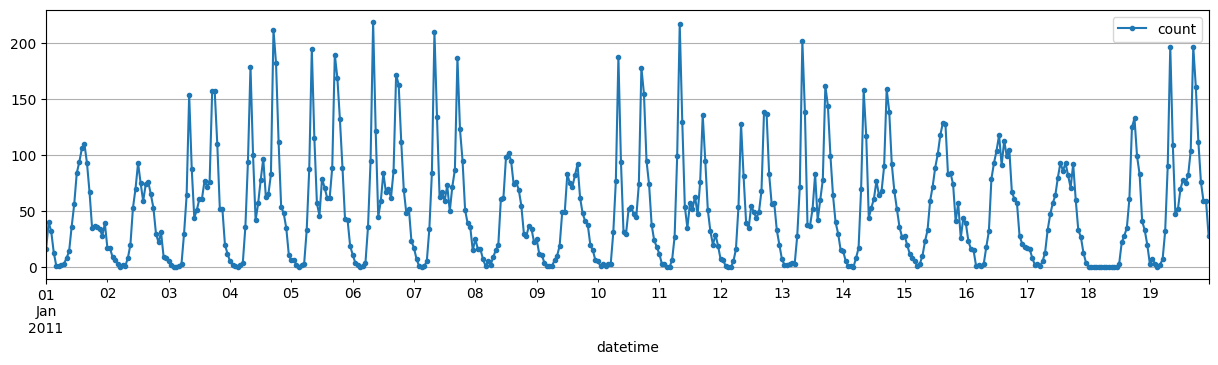

In [266]:
# A priori vamos a probar quitándonos las columnas casual y registered pues nuestra target es count y esta es la suma de las otras dos.
train_dt_null = train_dt_all.drop(['casual', 'registered'], axis=1).copy()
train_dt_null.index = pd.to_datetime(train_dt_null.index)


train_dt_null.loc["2011-01-01":"2011-01-19", ['count']].plot(grid=True, marker=".", figsize=(15, 3.5)) # Esto sería un mes
plt.show()

In [267]:
# Vamos a separar en un date set para entrenar y otro para validación, ya que el test, lo tenemos ya separado y es lo que se sube a kaggle.
# Como las semanas son de 7 días y es el periodo más corto que vamos a tener, vamos a depararlo en 14 y 5 días. 

dias_train= []
dias_eval= []
dias_comprobables = []

train_months = []
eval_months = []

for año in range(1,3):
    for mes in range(1,13):
        dias_mes_train = pd.date_range(start=f"201{año}-{mes}-01", end=f"201{año}-{mes}-14").strftime('%Y-%m-%d').tolist()
        dias_train.extend(dias_mes_train)
        train_months.append(dias_mes_train)

for año in range(1,3):
    for mes in range(1,13):
        dias_mes_eval = pd.date_range(start=f"201{año}-{mes}-15", end=f"201{año}-{mes}-19").strftime('%Y-%m-%d').tolist()
        dias_eval.extend(dias_mes_eval)
        eval_months.append(dias_mes_eval)

for año in range(1,3):
    for mes in range(1,13):
        dias_mes_comp = pd.date_range(start=f"201{año}-{mes}-08", end=f"201{año}-{mes}-19").strftime('%Y-%m-%d').tolist()
        dias_comprobables.extend(dias_mes_comp)

train_ = train_dt_null.loc[dias_train]
eval_ = train_dt_null.loc[dias_eval]
test_ = pd.read_csv('./data_bike_sharing/test.csv')

In [268]:
diff_7 = train_dt_null['count'].diff(7*24)

# Convertir dias_comprobables a datetime.date para la comparación, si aún no lo están
dias_comprobables = [pd.to_datetime(dia).date() for dia in dias_comprobables]

# Filtrar diff_7 para incluir solo los registros cuyas fechas están en dias_comprobables
diff_7_filtrado = diff_7[pd.to_datetime(diff_7.index.date).isin(dias_comprobables)]

mae_naive = diff_7_filtrado.mean()

valores_reales = train_dt_null[pd.to_datetime(train_dt_null.index.date).isin(dias_comprobables)]['count'].values
valores_reales_modificados = np.where(valores_reales == 0, 1, valores_reales)        # Sustituimos los 0 por un valor pequeño para evitar errores
ape = np.abs(diff_7_filtrado.values / valores_reales_modificados) * 100
mape_naive = np.mean(ape)

# Generar predicciones naive desplazando la columna 'count'
predicciones_naive = train_dt_null['count'].shift(7*24)

# Excluir valores NaN resultantes del desplazamiento inicial para las predicciones
valid_indices = predicciones_naive.notna() & train_dt_null['count'].notna()
predicciones_naive_validas = predicciones_naive[valid_indices]
valores_reales_validos = train_dt_null['count'][valid_indices]

# Calcular los logaritmos añadiendo 1 para evitar el logaritmo de 0
log_predicciones = np.log1p(predicciones_naive_validas)
log_valores_reales = np.log1p(valores_reales_validos)

# Calcular las diferencias cuadradas
diferencias_cuadradas = (log_predicciones - log_valores_reales) ** 2

# Calcular RMSLE
rmsle_naive = np.sqrt(diferencias_cuadradas.mean())



print(f'El MAE de nuestro método naive a 7 días es {mae_naive: .3f}')
print(f"EL MAPE de nuestro método naive a 7 días es {mape_naive:.3f}%")
print(f"El RMSLE de nuestro método naive a 7 días es {rmsle_naive:.3f}")

El MAE de nuestro método naive a 7 días es  4.380
EL MAPE de nuestro método naive a 7 días es 53.458%
El RMSLE de nuestro método naive a 7 días es 0.734


In [269]:
# Vamos a comporobar la estacionariedad
from statsmodels.tsa.stattools import adfuller

serie_temporal = train_dt_null['count']

resultado_adf = adfuller(serie_temporal.dropna())

print('Estadístico ADF:', resultado_adf[0])
print('p-valor:', resultado_adf[1])
print('Valores Críticos:')
for key, value in resultado_adf[4].items():
    print(f'    {key}: {value}')

# Interpretación básica del resultado
if resultado_adf[1] < 0.05:
    print("La serie temporal es estacionaria con un 95% de confianza.")
else:
    print("La serie temporal no es estacionaria.")

Estadístico ADF: -6.2552514945639235
p-valor: 4.3548435345867385e-08
Valores Críticos:
    1%: -3.430949581941237
    5%: -2.861804981983349
    10%: -2.5669110447789727
La serie temporal es estacionaria con un 95% de confianza.


#### Ahroa vamos a por el AUTO SARIMA. Como tenemos unos periodos cortados, vamos a entrenar modelos para cada uno de los periodos y luego haremos el MAE y MAPE y RMSLE.

In [270]:
# mae_list = []
# mape_list = []
# rmsle_list = []

# for train_data, eval_data in zip(train_months, eval_months):  # Cada month_data es una lista de valores reales para un mes específico

#     train_m = train_dt_null[pd.to_datetime(train_dt_null.index.date).isin(train_data)]
#     eval_m = train_dt_null[pd.to_datetime(train_dt_null.index.date).isin(eval_data)]

#     model = auto_arima(train_m['count'], start_p=1, start_q=1,
#                    start_P=1, start_Q=1, 
#                    seasonal=True, m=24, d=1, D=1,
#                    stepwise=True, trace=True, # trace=True muestra el proceso de búsqueda
#                    error_action='ignore',  # no detenerse en modelos que no convergen
#                    suppress_warnings=True,  # suprimir advertencias de modelos que no convergen
#                    verbose = 0
#                    )
    
#     periods = len(eval_m)  # El número de períodos para predecir
#     predicted = model.predict(n_periods=periods, vercose = 0)

#     count_data = eval_m['count']
#     # Asegúrate de convertir month_data a un array de NumPy para realizar operaciones vectorizadas
#     real_values = np.array(count_data)

#     # Reemplazar los 0 con 1e-5 en los valores reales para evitar división por cero en el cálculo del MAPE
#     real_values_modified = np.where(real_values == 0, 1e-5, real_values)

#     # Calcular el MAE
#     mae = mean_absolute_error(real_values_modified, predicted)
#     mae_list.append(mae)

#     # Calcular el APE y luego el MAPE
#     ape = np.abs((real_values_modified - predicted) / real_values_modified) * 100
#     mape = ape.mean()
#     mape_list.append(mape)

#     # Cálculo del RMSLE
#     # Excluir valores NaN resultantes
#     valid_indices = predicted.notna() & train_dt_null['count'].notna()
#     predicciones_validas = predicted[valid_indices]
#     valores_reales_validos = train_dt_null['count'][valid_indices]

#     # Calcular los logaritmos añadiendo 1 para evitar el logaritmo de 0
#     log_predicciones = np.log1p(predicciones_validas)
#     log_valores_reales = np.log1p(valores_reales_validos)

#     # Calcular las diferencias cuadradas
#     diferencias_cuadradas = (log_predicciones - log_valores_reales) ** 2

#     # Calcular RMSLE
#     rmsle = np.sqrt(diferencias_cuadradas.mean())
#     rmsle_list.append(rmsle)

# # Calcular el MAE y el MAPE promedio de todos los meses
# mae_auto_sarima = np.mean(mae_list)
# mape_auto_sarima = np.mean(mape_list)
# rmsle_auto_sarima = np.mean(rmsle_list)


# print(f'El MAE promedio de nuestro Auto Sarima es: {mae_auto_sarima:.3f}')
# print(f'El MAPE promedio de nuestro Auto Sarima es: {mape_auto_sarima:.3f}%')
# print(f"El RMSLE de nuestro método naive a 7 días es {rmsle_auto_sarima:.3f}")

El proceso anterior tarda mucho y los resultados no son últiles así que los expongo aquí para no tener que ejecutarlo cada vez.

El MAE promedio de nuestro Auto Sarima es: 110.444

El MAPE promedio de nuestro Auto Sarima es: 2886416.649%

El RMSLE de nuestro método naive a 7 días es 1.078

In [271]:
# El Auto Sarima da un resultado bastante malo, probablemente porque tiene muy pocos datos para entrenar, solo 14 días. Para sacar 5.
# Así pues, tomaremos como baseline el naive. 
print(f'El MAE de nuestro método naive a 7 días es {mae_naive: .3f}')
print(f"EL MAPE de nuestro método naive a 7 días es {mape_naive:.3f}%")
print(f"El RMSLE de nuestro método naive a 7 días es {rmsle_naive:.3f}")

El MAE de nuestro método naive a 7 días es  4.380
EL MAPE de nuestro método naive a 7 días es 53.458%
El RMSLE de nuestro método naive a 7 días es 0.734


## Probamos un enfoque diferente.

Ahora que ya tenemos la baseline con los cálculos de los errores MAE, MAPE y RMSLE vamos a probar un enfoque diferente.

Tenida en cuenta la dificultad que tenía el tratamiento de las series temporales con datos no continuos, ahora intentaremos enfocarlo de tal manera que translademos los datos de las fechas, a datos categóricos tal y como hacemos a continuación.

### Tratamiento y limpieza de los datos

In [272]:
# Tratamos la fecha para que nos diga algo. Seguiremos excluyendo casual y registered.
train = train_dt_all.reset_index().copy()
train = train.drop(['casual', 'registered'], axis=1)
train['datetime'] = train['datetime'].astype(str)
train["date"] = train["datetime"].apply(lambda x: x.split()[0])
train["hour"] = train["datetime"].apply(lambda x: x.split()[1].split(":")[0]).astype(int)
train["year"] = train["date"].apply(lambda x: x.split("-")[0]).astype(int)
train["month"] = train["date"].apply(lambda x: x.split("-")[1]).astype(int)
train["weekday"] = train["date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").weekday()).astype(int)

train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,date,hour,year,month,weekday
0,2011-01-01 00:00:00,1.0,0.0,0.0,1.0,9.84,14.395,81.0,0.0,16.0,2011-01-01,0,2011,1,5
1,2011-01-01 01:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0,40.0,2011-01-01,1,2011,1,5
2,2011-01-01 02:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0,32.0,2011-01-01,2,2011,1,5
3,2011-01-01 03:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0,13.0,2011-01-01,3,2011,1,5
4,2011-01-01 04:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0,1.0,2011-01-01,4,2011,1,5


In [273]:
std = fn.crea_df_std(train)
std

,name,type,prio,card,card%,NaN,Unknown,%_NaN,Category
0,datetime,object,3,10944,100.00,0,0,0.0,Categórica
1,season,float64,3,4,0.04,0,0,0.0,Categórica
2,holiday,float64,3,2,0.02,0,0,0.0,Binaria
3,workingday,float64,3,2,0.02,0,0,0.0,Binaria
4,weather,float64,3,4,0.04,0,0,0.0,Categórica
5,temp,float64,3,63,0.58,0,0,0.0,Numérica Discreta
6,atemp,float64,3,80,0.73,0,0,0.0,Numérica Discreta
7,humidity,float64,3,101,0.92,0,0,0.0,Numérica Discreta
8,windspeed,float64,3,50,0.46,0,0,0.0,Numérica Discreta
9,count,float64,3,823,7.52,0,0,0.0,Numérica Continua


In [274]:
train.drop(['datetime', 'year', 'date'], axis=1, inplace=True)

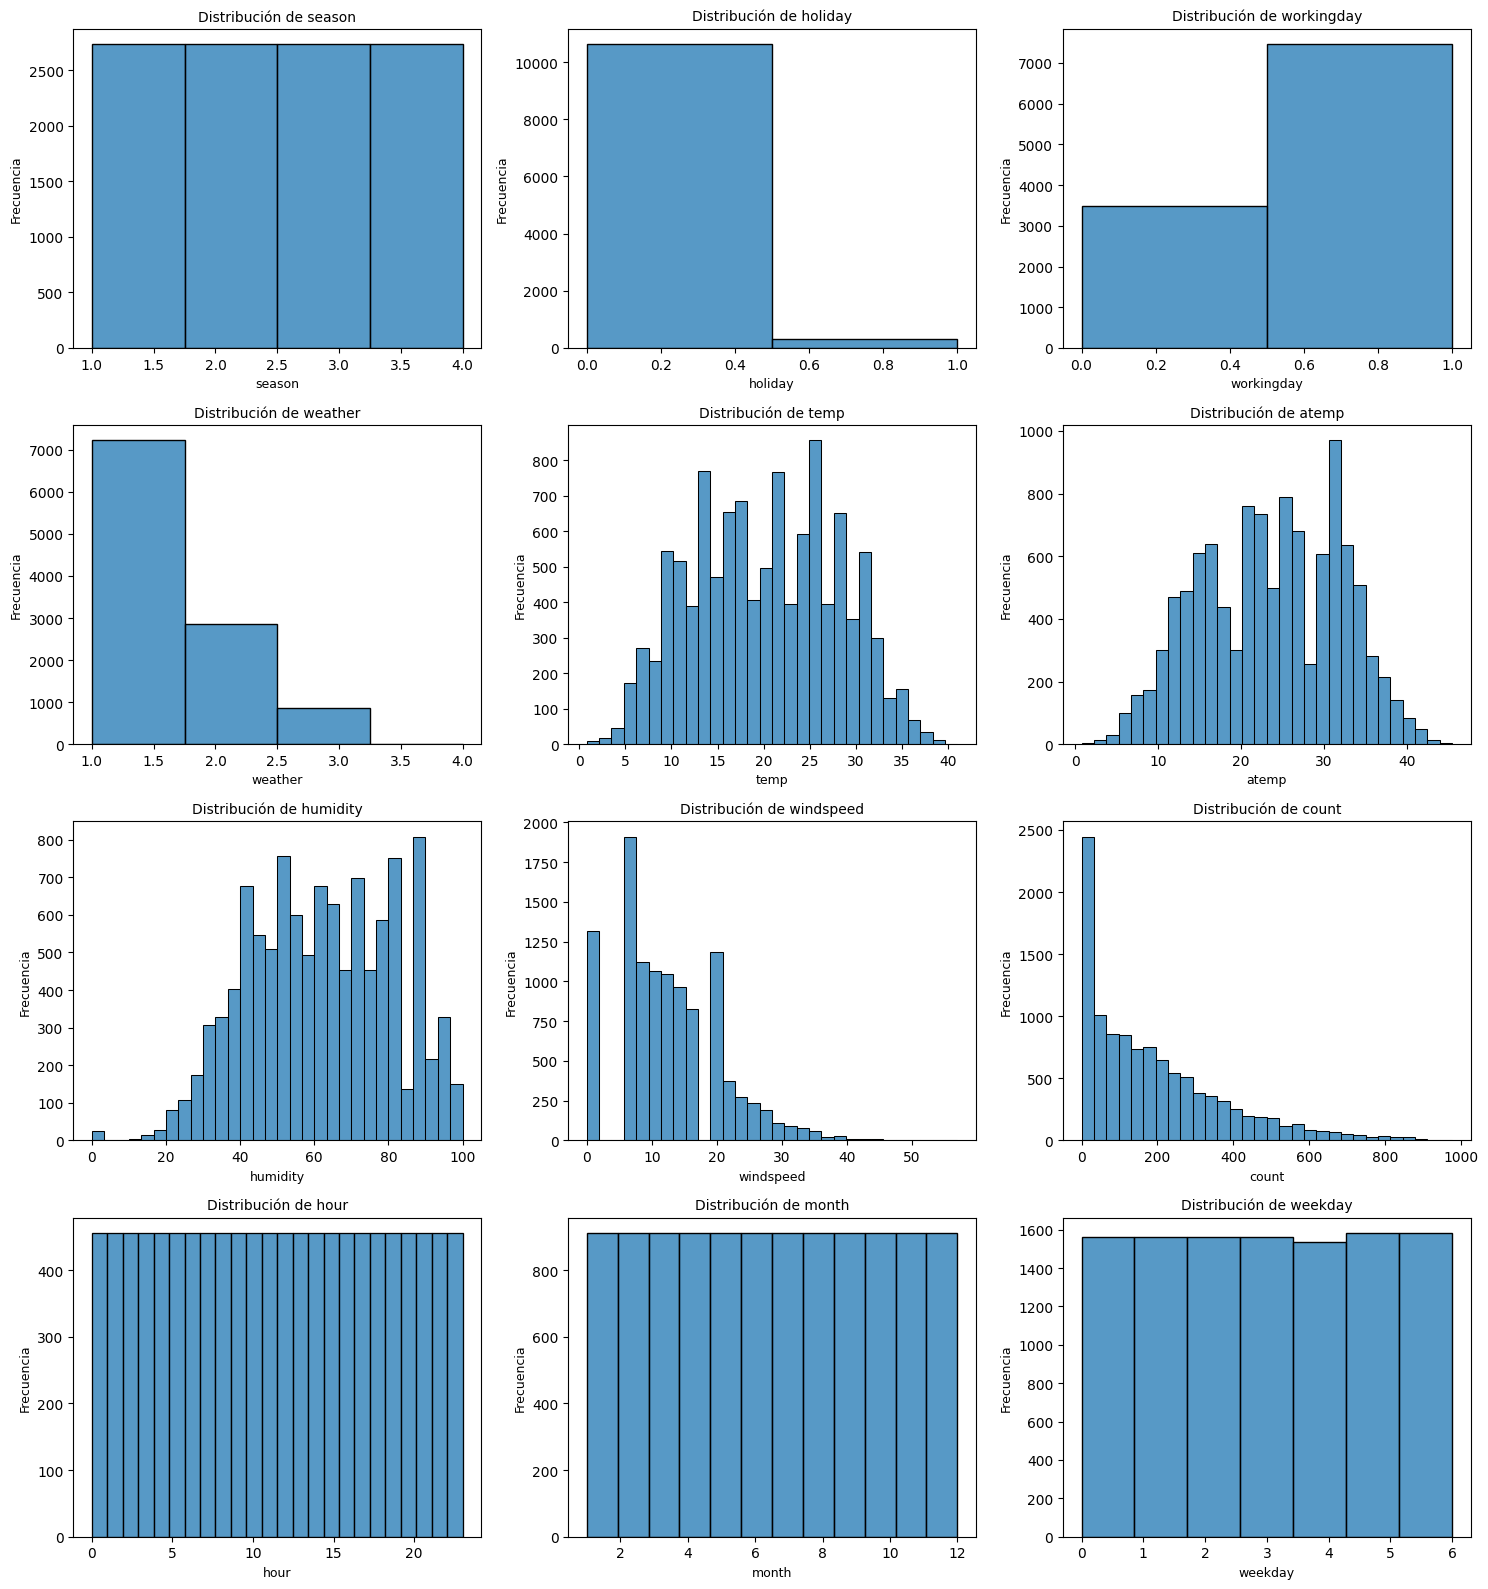

In [275]:
nf.plot_all_columns_in_subplots(train)

<Axes: >

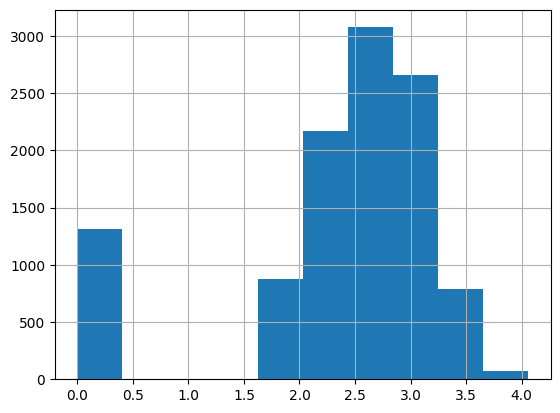

In [276]:
train['windspeed_log'] = np.log1p(train['windspeed'])
train['windspeed_log'].hist()

In [277]:
train.drop('windspeed', axis = 1, inplace = True)

c:\Users\jcrub\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


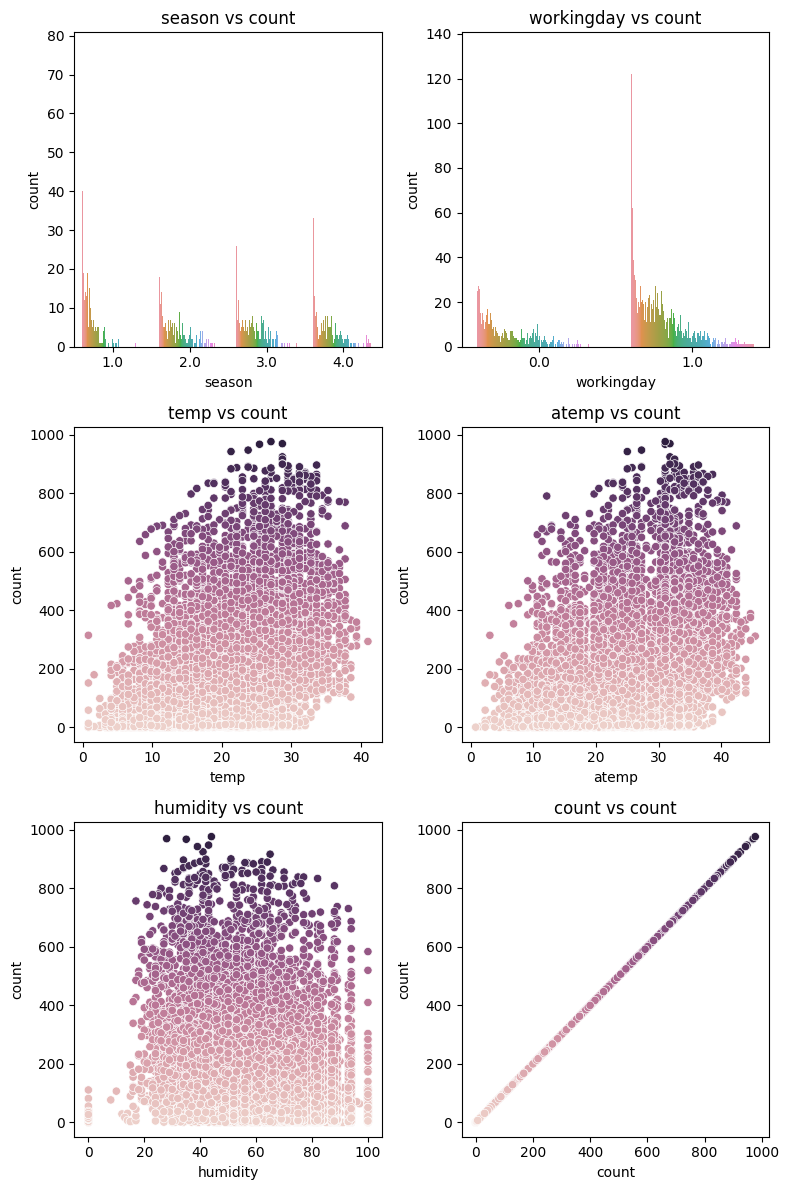

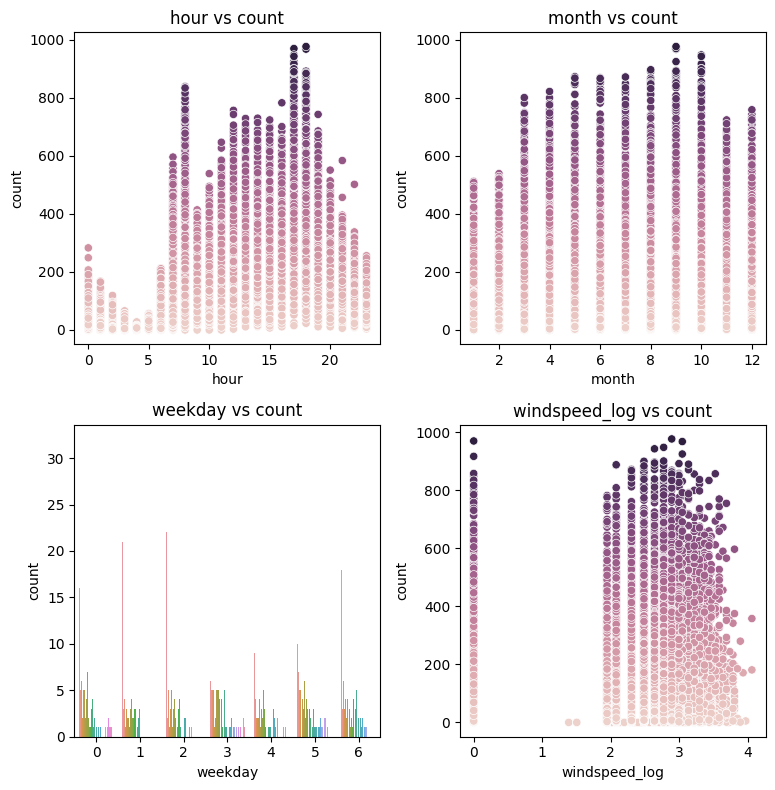

['season',
 'workingday',
 'temp',
 'atemp',
 'humidity',
 'count',
 'hour',
 'month',
 'weekday',
 'windspeed_log']

In [278]:
t2.plot_features_cat_num_classification(train, 'count', max_plots= 6)

[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Users Count'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across Weekdays'),
 None]

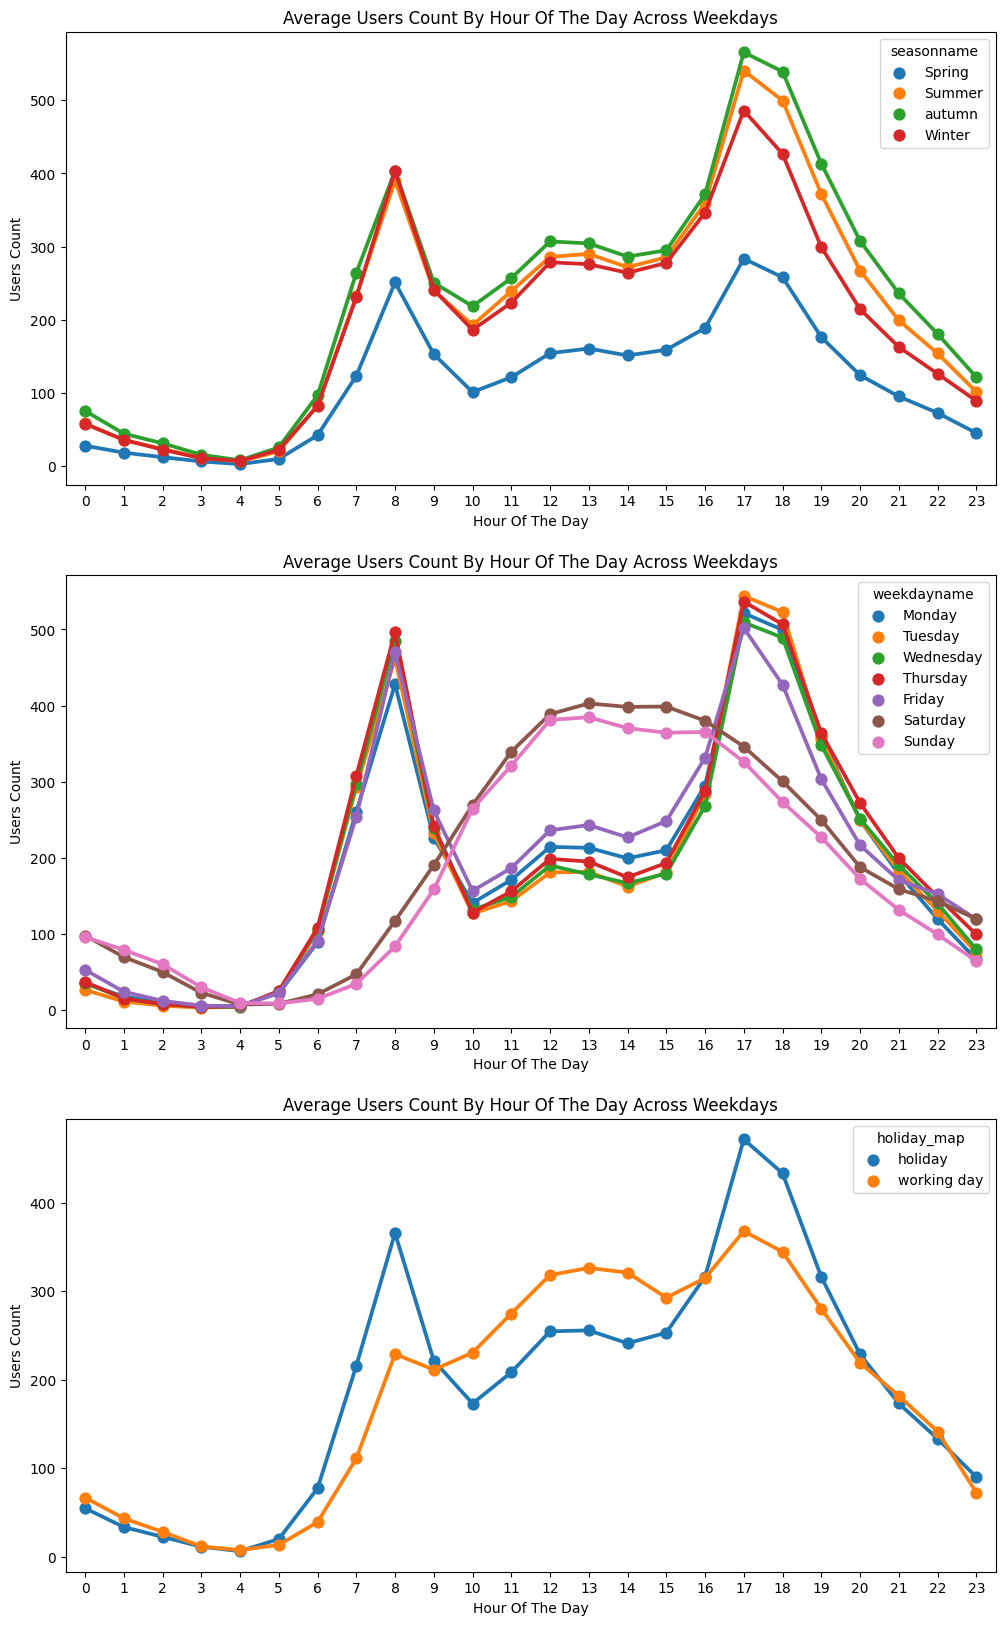

In [279]:
fig,(ax1,ax2,ax3)= plt.subplots(nrows=3)
fig.set_size_inches(12,20)

hour_season = pd.DataFrame(train.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
hour_season["seasonname"] = hour_season.season.map({1: "Spring", 2 : "Summer", 3 : "autumn", 4 :"Winter" })
sns.pointplot(x=hour_season["hour"], y=hour_season["count"],hue=hour_season["seasonname"], data=hour_season, join=True,ax=ax1)
ax1.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

hour_weekday = pd.DataFrame(train.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
hour_weekday["weekdayname"] = hour_weekday.weekday.apply(lambda x: calendar.day_name[x])
sns.pointplot(x=hour_weekday["hour"], y=hour_weekday["count"],hue=hour_weekday["weekdayname"], data=hour_weekday, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')


hour_holiday = pd.DataFrame(train.groupby(["hour", "holiday"],sort=True)["count"].mean()).reset_index()
hour_holiday["holiday_map"] = hour_holiday.holiday.map({0:"holiday", 1:"working day"})
sns.pointplot(x=hour_holiday["hour"], y=hour_holiday["count"],hue=hour_holiday["holiday_map"], data=hour_holiday, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

<Axes: >

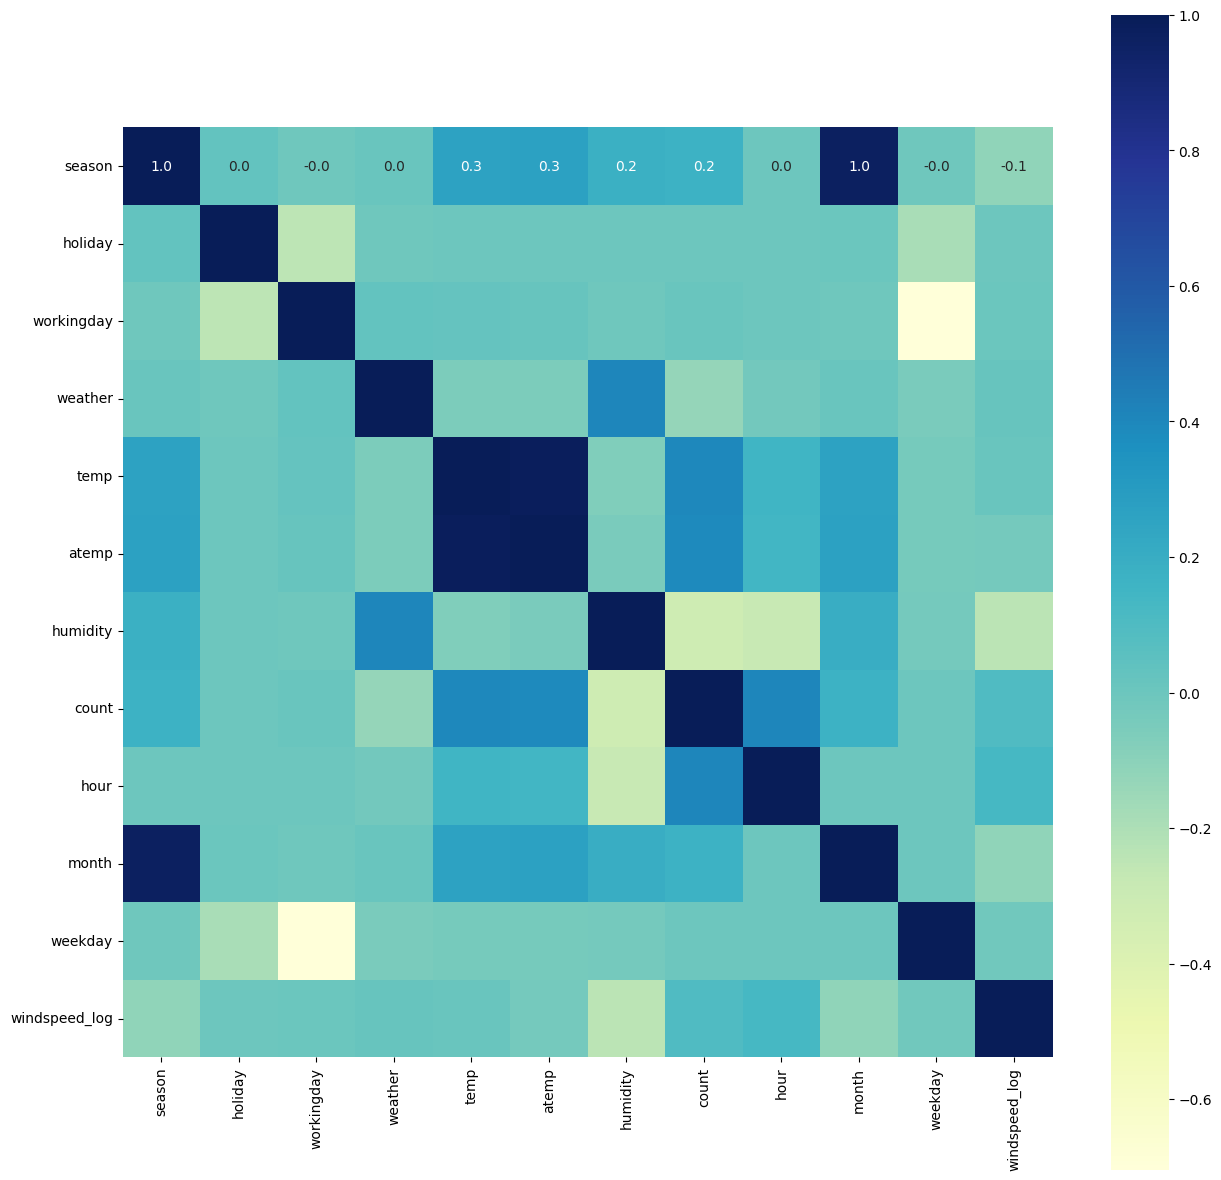

In [280]:
corr = train.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, cbar=True, square= True, fmt='.1f', annot=True, annot_kws={'size':10}, cmap='YlGnBu')

In [281]:
train.drop(['atemp', 'season'], axis = 1, inplace = True)

### Entrenamos los modelos

In [319]:
train_shuffled = train.sample(frac=1, random_state= 42)

X = train_shuffled.drop('count', axis=1)
y = train_shuffled['count']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [320]:
scaler_1 = MinMaxScaler()
scaler = MinMaxScaler()
num = ['temp', 'windspeed_log', 'weather', 'humidity']

# Ajustar el escalador solo con los datos de entrenamiento
scaler_1.fit(X[num])
scaler.fit(X_train[num])

# Transformar los conjuntos de datos con el escalador ajustado
X_scaled = scaler_1.transform(X[num])
X_train_scaled = scaler.transform(X_train[num])
X_val_scaled = scaler.transform(X_val[num])

# Convertir de nuevo a DataFrame manteniendo el índice original
X_scaled_df = pd.DataFrame(X_scaled, columns=num, index=X.index)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=num, index=X_train.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=num, index=X_val.index)


# Combinar las columnas escaladas con las no escaladas
# Para X
X_non_scaled = X.drop(columns=num)
X_normalized = pd.concat([X_scaled_df, X_non_scaled], axis=1)

# Para X_train
X_train_non_scaled = X_train.drop(columns=num)
X_train_normalized = pd.concat([X_train_scaled_df, X_train_non_scaled], axis=1)

# Para X_val
X_val_non_scaled = X_val.drop(columns=num)
X_val_normalized = pd.concat([X_val_scaled_df, X_val_non_scaled], axis=1)

# Asegúrarse de que el orden de las columnas en los DataFrames escalados coincide con el orden en X
X_normalized = X_normalized[X.columns]
X_train_normalized = X_train_normalized[X_train.columns]
X_val_normalized = X_val_normalized[X_val.columns]


In [321]:
cat = ['hour', 'month', 'weekday']                                    # One hot Encoding de las categóricas

def one_hot_encoding(df, column):
    # Realizar one-hot encoding y concatenar con el DataFrame original
    dummies = pd.get_dummies(df[column], prefix=column, drop_first=True).astype(int)
    df = pd.concat([df.drop([column], axis=1), dummies], axis=1)
    
    return df

for i in cat:
    X_normalized = one_hot_encoding(X_normalized, i)
    X_train_normalized = one_hot_encoding(X_train_normalized, i)
    X_val_normalized = one_hot_encoding(X_val_normalized, i)


#### Vamos a probar rápido con algunos modelos para ver su rendimiento

In [285]:
# Función para calcular los scores, ajustando los valores de y_true que son 0
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true_adjusted = np.where(y_true == 0, 1e-5, y_true)  # Ajuste para evitar división por cero
    return np.mean(np.abs((y_true_adjusted - y_pred) / y_true_adjusted)) * 100

# Función para calcular el RMSLE
def root_mean_squared_log_error(y_true, y_pred):
    min_val = 1e-5
    log_true = np.log(np.where(y_true < min_val, min_val, y_true) + 1)
    log_pred = np.log(np.where(y_pred < min_val, min_val, y_pred) + 1)
    return np.sqrt(np.mean((log_true - log_pred) ** 2))

# Convertir las funciones a scorers de scikit-learn
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
rmsle_scorer = make_scorer(root_mean_squared_log_error, greater_is_better=False)

# Diccionario para almacenar los resultados
results = {}

# Lista de modelos a evaluar con hiperparámetros básicos
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'SVR': SVR(C=1.0, epsilon=0.1),
    'DecisionTreeRegressor': DecisionTreeRegressor(max_depth=5),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, max_depth=5),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3),
    'XGBRegressor': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=15, random_state = 42),
    'LGBMRegressor': lgb.LGBMRegressor(num_leaves=31, learning_rate=0.1, n_estimators=100, verbose = 0),
    'CatBoostRegressor': cb.CatBoostRegressor(depth=3, learning_rate=0.1, n_estimators=100, verbose=0)
}

# Entrenar y evaluar cada modelo
for name, model in models.items():
    # Validación cruzada para MAE
    scores_mae = cross_val_score(model, X_train_normalized, y_train, cv=5, scoring='neg_mean_absolute_error', verbose= 0)
    mae = -scores_mae.mean()  # Negativo porque scikit-learn devuelve valores negativos para los errores
    
    # Validación cruzada para MAPE
    scores_mape = cross_val_score(model, X_train_normalized, y_train, cv=5, scoring=mape_scorer, verbose = 0)
    mape = -scores_mape.mean()
    
    # Validación cruzada para RMSLE
    scores_rmsle = cross_val_score(model, X_train_normalized, y_train, cv=5, scoring=rmsle_scorer, verbose = 0)
    rmsle = -scores_rmsle.mean()
    # Almacenar los resultados incluyendo la diferencia con el baseline
    results[name] = {
        'MAE': mae, 
        'MAE_Diff_Baseline': mae - mae_naive, 
        'MAPE': mape, 
        'MAPE_Diff_Baseline': mape - mape_naive,
        'RMSLE': rmsle,
        'RMSLE_Diff_Baseline': rmsle - rmsle_naive
    }

# Convertir los resultados a un DataFrame de Pandas
results_df = pd.DataFrame(results).T

In [286]:
results_df_formatted = results_df.applymap(lambda x: '{:.10f}'.format(x))

results_df_formatted

,MAE,MAE_Diff_Baseline,MAPE,MAPE_Diff_Baseline,RMSLE,RMSLE_Diff_Baseline
LinearRegression,79.6674045077,75.2870514984,3395106.3892800175,3395052.9309146334,1.0696860120,0.3360499756
Ridge,79.6607244739,75.2803714646,3365036.4965403052,3364983.0381749212,1.0643051042,0.3306690678
Lasso,79.7005965983,75.3202435890,3181922.2412731680,3181868.7829077840,1.0524771506,0.3188411143
ElasticNet,100.3937745155,96.0134215063,3540599.9687087731,3540546.5103433891,1.2656639097,0.5320278734
SVR,111.5946497769,107.2142967676,3202890.0564282350,3202836.5980628510,1.2376321654,0.5039961290
DecisionTreeRegressor,101.2496203333,96.8692673241,4409156.4788486855,4409103.0204833020,1.3321558698,0.5985198334
RandomForestRegressor,96.5805687848,92.2002157756,4384934.2667746665,4384880.8084092829,1.3186120986,0.5849760622
GradientBoostingRegressor,66.8606984407,62.4803454315,1709610.0498339017,1709556.5914685179,0.8556541200,0.1220180836
XGBRegressor,51.5534775048,47.1731244955,808234.2426200376,808180.7842546537,0.6005609618,-0.1330750745
LGBMRegressor,51.4925784973,47.1122254881,1090371.5909839855,1090318.1326186017,0.7576572694,0.0240212330


In [287]:
selection_1 = ['GradientBoostingRegressor', 'XGBRegressor', 'LGBMRegressor']       # Hacemos una selección de los mejores modelos

#### Ahora ajustamos los hiperparámetros de los selecionados

In [288]:
model_names = [
    'Ridge',
    'Lasso',
    'ElasticNet',
    'SVR',
    'DecisionTreeRegressor',
    'RandomForestRegressor',
    'GradientBoostingRegressor',
    'XGBRegressor',
    'LGBMRegressor',
    'CatBoostRegressor'
]

In [289]:
def opt_gridseach(model_names = 'all', ampliacion_busqueda = 1, custom_hyperparams=None):

    best_hyperparameters = {}

    if custom_hyperparams is None:
        custom_hyperparams = {}

    if isinstance(model_names, str):
        if model_names.upper() == 'ALL':                    # Si pone all, seleccionamos todas
            model_names = [                                
                'Ridge',
                'Lasso',
                'ElasticNet',
                'SVR',
                'DecisionTreeRegressor',
                'RandomForestRegressor',
                'GradientBoostingRegressor',
                'XGBRegressor',
                'LGBMRegressor',
                'CatBoostRegressor'
            ]
        else: 
            model_names = [model_names]

    param_grid_dict = {                                                            # Diccionario con los rangos de los hiperparámetros
        'Ridge': {
            'alpha': np.logspace(-2, 2, int(10 * ampliacion_busqueda))
        },
        'Lasso': {
            'alpha': np.logspace(-2, 2, int(10 * ampliacion_busqueda))
        },
        'ElasticNet': {
            'alpha': np.logspace(-2, 2, int(10 * ampliacion_busqueda)),
            'l1_ratio': np.linspace(0, 1, int(10 * ampliacion_busqueda))
        },
        'SVR': {
            'C': np.logspace(-2, 2, int(10 * ampliacion_busqueda)),
            'epsilon': np.logspace(-4, 0, int(10 * ampliacion_busqueda)),
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
        },
        'DecisionTreeRegressor': {
            'max_depth': np.arange(1, 33, int(3 / ampliacion_busqueda)),
            'min_samples_split': np.arange(2, 11, int(2 / ampliacion_busqueda)),
            'min_samples_leaf': np.arange(1, 11, int(2 / ampliacion_busqueda))
        },
        'RandomForestRegressor': {
            'n_estimators': np.arange(10, 201, int(20 / ampliacion_busqueda)),
            'max_depth': np.arange(3, 33, int(3 / ampliacion_busqueda)),
            'min_samples_split': np.arange(2, 11, int(2 / ampliacion_busqueda)),
            'min_samples_leaf': np.arange(1, 11, int(2 / ampliacion_busqueda))
        },
        'GradientBoostingRegressor': {
            'n_estimators': np.arange(10, 201, int(20 / ampliacion_busqueda)),
            'learning_rate': np.logspace(-3, 0, int(10 * ampliacion_busqueda)),
            'max_depth': np.arange(3, 33, int(3 / ampliacion_busqueda)),
            'min_samples_split': np.arange(2, 11, int(2 / ampliacion_busqueda))
        },
        'XGBRegressor': {
            'n_estimators': np.arange(10, 201, int(20 / ampliacion_busqueda)),
            'max_depth': np.arange(3, 33, int(3 / ampliacion_busqueda)),
            'learning_rate': np.logspace(-3, 0, int(10 * ampliacion_busqueda)),
            'subsample': np.linspace(0.5, 1.0, int(6 * ampliacion_busqueda)),
            'colsample_bytree': np.linspace(0.5, 1.0, int(6 * ampliacion_busqueda))
        },
        'LGBMRegressor': {
            'num_leaves': np.arange(31, 201, int(17 / ampliacion_busqueda)),
            'learning_rate': np.logspace(-3, 0, int(10 * ampliacion_busqueda)),
            'n_estimators': np.arange(10, 201, int(20 / ampliacion_busqueda)),
            'subsample': np.linspace(0.5, 1.0, int(6 * ampliacion_busqueda)),
            'colsample_bytree': np.linspace(0.5, 1.0, int(6 * ampliacion_busqueda)),
            'max_depth': np.arange(-1, 33, int(3 / ampliacion_busqueda))
        },
        'CatBoostRegressor': {
            'depth': np.arange(4, 11, int(2 / ampliacion_busqueda)),
            'learning_rate': np.logspace(-3, 0, int(10 * ampliacion_busqueda)),
            'n_estimators': np.arange(10, 201, int(20 / ampliacion_busqueda)),
            'subsample': np.linspace(0.5, 1.0, int(6 * ampliacion_busqueda)),
            'l2_leaf_reg': np.logspace(-2, 1, int(10 * ampliacion_busqueda))
        }
    }
    
    # Preparamos para instanciar los modelos
    model_instances_dict = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'SVR': SVR(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'XGBRegressor': xgb.XGBRegressor(objective='reg:squarederror'),
    'LGBMRegressor': lgb.LGBMRegressor(),
    'CatBoostRegressor': cb.CatBoostRegressor(verbose=0)
    }


    for model in model_names:
        if model in param_grid_dict:
            print(f"Optimizando {model} con Grid Search...")

            # Utilizar hiperparámetros personalizados si están disponibles; de lo contrario, usar los por defecto
            if model in custom_hyperparams:
                param_grid = custom_hyperparams[model]
            else:
                param_grid = param_grid_dict[model]

            grid_search = GridSearchCV(estimator=model_instances_dict[model], param_grid=param_grid,
                                    scoring=rmsle_scorer, cv=5, verbose=1, n_jobs=-1)

            grid_search.fit(X_train_normalized, y_train)

            best_hyperparameters[model] = grid_search.best_params_  

            print(f"Mejores hiperparámetros para {model}: {grid_search.best_params_}")
            print(f"Mejor score (RMSLE) para {model}: {-grid_search.best_score_}\n")
        else:
            print(f"No hay un grid definido para {model}")

    return best_hyperparameters

In [290]:
sel_best_hyper = opt_gridseach(model_names= selection_1, ampliacion_busqueda= 0.51)

Optimizando GradientBoostingRegressor con Grid Search...
Fitting 5 folds for each of 450 candidates, totalling 2250 fits
Mejores hiperparámetros para GradientBoostingRegressor: {'learning_rate': 0.03162277660168379, 'max_depth': 28, 'min_samples_split': 8, 'n_estimators': 166}
Mejor score (RMSLE) para GradientBoostingRegressor: 0.5639441307728429

Optimizando XGBRegressor con Grid Search...
Fitting 5 folds for each of 1350 candidates, totalling 6750 fits
Mejores hiperparámetros para XGBRegressor: {'colsample_bytree': 1.0, 'learning_rate': 0.03162277660168379, 'max_depth': 28, 'n_estimators': 166, 'subsample': 0.75}
Mejor score (RMSLE) para XGBRegressor: 0.5456244458993227

Optimizando LGBMRegressor con Grid Search...
Fitting 5 folds for each of 9450 candidates, totalling 47250 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 248
[LightGBM] [

Añádimos nuevos modelos a la lista de los seleccionados para seguir probando con ellos.

In [291]:
selection_2 = []

model_selection_list = selection_1 + selection_2
model_selection_list
model_selection_list_best_hyper = {model: params for model, params in sel_best_hyper.items() if model in model_selection_list}
model_selection_list_best_hyper

{'GradientBoostingRegressor': {'learning_rate': 0.03162277660168379,
  'max_depth': 28,
  'min_samples_split': 8,
  'n_estimators': 166},
 'XGBRegressor': {'colsample_bytree': 1.0,
  'learning_rate': 0.03162277660168379,
  'max_depth': 28,
  'n_estimators': 166,
  'subsample': 0.75},
 'LGBMRegressor': {'colsample_bytree': 0.75,
  'learning_rate': 0.03162277660168379,
  'max_depth': 24,
  'n_estimators': 127,
  'num_leaves': 163,
  'subsample': 0.5}}

#### Con los modelos y sus hiperparámetros seleccionados vamos a darle otra vuelta

In [292]:
best_hyperparameters =  {                   # Aquí el diccionario con los mejores hiperparámetros
    'GradientBoostingRegressor': {'learning_rate': 0.03162277660168379,
  'max_depth': 28,
  'min_samples_split': 8,
  'n_estimators': 166},

 'XGBRegressor': {'colsample_bytree': 1.0,
  'learning_rate': 0.03162277660168379,
  'max_depth': 28,
  'n_estimators': 166,
  'subsample': 0.75},
  
 'LGBMRegressor': {'colsample_bytree': 0.75,
  'learning_rate': 0.03162277660168379,
  'max_depth': 24,
  'n_estimators': 127,
  'num_leaves': 163,
  'subsample': 0.5}
    }

In [ ]:
# Evaluar cada modelo de nuevo
model_performance = {}

for model_name, params in best_hyperparameters.items():

    params = {key: val[0] if isinstance(val, list) else val for key, val in params.items()}

    if model_name == 'LinearRegression':
        model = LinearRegression()
    elif model_name == 'Ridge':
        model = Ridge(**params)
    elif model_name == 'Lasso':
        model = Lasso(**params)
    elif model_name == 'ElasticNet':
        model = ElasticNet(**params)
    elif model_name == 'SVR':
        model = SVR(**params)
    elif model_name == 'DecisionTreeRegressor':
        model = DecisionTreeRegressor(**params)
    elif model_name == 'RandomForestRegressor':
        model = RandomForestRegressor(**params)
    elif model_name == 'GradientBoostingRegressor':
        model = GradientBoostingRegressor(**params)
    elif model_name == 'XGBRegressor':
        model = xgb.XGBRegressor(**params)
    elif model_name == 'LGBMRegressor':
        model = lgb.LGBMRegressor(**params)
    elif model_name == 'CatBoostRegressor':
        model = cb.CatBoostRegressor(**params)
    else:
        continue  # Saltar si el modelo no está reconocido
    
    # Evalúa el modelo con validación cruzada
    scores = cross_val_score(model, X_train_normalized, y_train, scoring=rmsle_scorer, cv=5)
    
    # Guarda la media de los scores como rendimiento del modelo
    model_performance[model_name] = np.abs(np.mean(scores))

# Selecciona los 5 modelos con mejor rendimiento
best_4_models = sorted(model_performance, key=model_performance.get)[:4]

# Muestra los 5 mejores modelos y su rendimiento
print("Los 4 mejores modelos y su rendimiento (RMSLE):")
for model in best_4_models:
    print(f"{model}: {model_performance[model]}")

In [295]:
model_performance

{'GradientBoostingRegressor': 0.5648212307995231,
 'XGBRegressor': 0.5456244458993227,
 'LGBMRegressor': 0.631077501136273}

#### Ahora evaluamos contra validación

In [296]:
model_evaluation_performance = {}

# Entrenar y evaluar los 4 mejores modelos
for model_name in best_4_models:

    params = best_hyperparameters[model_name]
    params = {key: val[0] if isinstance(val, list) else val for key, val in params.items()}

    if model_name == 'LinearRegression':
        model = LinearRegression()
    elif model_name == 'Ridge':
        model = Ridge(**params)
    elif model_name == 'Lasso':
        model = Lasso(**params)
    elif model_name == 'ElasticNet':
        model = ElasticNet(**params)
    elif model_name == 'SVR':
        model = SVR(**params)
    elif model_name == 'DecisionTreeRegressor':
        model = DecisionTreeRegressor(**params)
    elif model_name == 'RandomForestRegressor':
        model = RandomForestRegressor(**params)
    elif model_name == 'GradientBoostingRegressor':
        model = GradientBoostingRegressor(**params)
    elif model_name == 'XGBRegressor':
        model = xgb.XGBRegressor(**params)
    elif model_name == 'LGBMRegressor':
        model = lgb.LGBMRegressor(**params)
    elif model_name == 'CatBoostRegressor':
        model = cb.CatBoostRegressor(**params)
    
    # Entrenar el modelo
    model.fit(X_train_normalized, y_train)
    
    # Hacer predicciones en el conjunto de evaluación
    y_pred = model.predict(X_val_normalized)
    
    # Calcular RMSLE en el conjunto de evaluación
    rmsle_score = root_mean_squared_log_error(y_val, y_pred)
    
    # Almacenar el rendimiento del modelo
    model_evaluation_performance[model_name] = rmsle_score

# Mostrar el rendimiento de los 4 mejores modelos en el conjunto de evaluación
print("Rendimiento de los 4 mejores modelos en el conjunto de validación (RMSLE):")
for model in model_evaluation_performance:
    print(f"{model}: {model_evaluation_performance[model]}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 248
[LightGBM] [Info] Number of data points in the train set: 8755, number of used features: 46
[LightGBM] [Info] Start training from score 190.107253
Rendimiento de los 4 mejores modelos en el conjunto de validación (RMSLE):
XGBRegressor: 0.5063773397093668
GradientBoostingRegressor: 0.5233330994310037
LGBMRegressor: 0.5921671664151393


In [297]:
best_3_models = sorted(model_evaluation_performance, key=model_evaluation_performance.get)[:3]

# Aquí nos quitamos SVR que parece que no tiene futuro

# Preparar un nuevo diccionario para almacenar los mejores hiperparámetros después de la optimización con X_val_normalized
new_best_hyperparameters = {}

Y optimizamos más los hiperparámetros

*por alguna razón este paso está tomando mucho tiempo a ultima hora y no he podido ajustarlo así prescindiremos de él, lo dejo indicado para que se note que se había hecho anteriormente.*

In [305]:
def generate_param_ranges(params, factor=0.1):
    """Genera nuevos rangos de hiperparámetros basados en un factor."""
    new_params = {}
    for key, value in params.items():
        if isinstance(value, int):  # Para hiperparámetros enteros
            lower = value - int(value * factor)
            upper = value + int(value * factor)
            new_params[key] = (max(1, lower), upper)  # Asegura un mínimo de 1
        elif isinstance(value, float):  # Para hiperparámetros flotantes
            lower = value * (1 - factor)
            upper = value * (1 + factor)
            new_params[key] = (max(1e-5, lower), upper)  # Asegura un mínimo positivo
        elif isinstance(value, list):  # Para listas, como en 'kernel'
            new_params[key] = value  # Se asume lista de categorías sin cambios
        else:
            raise ValueError(f"Tipo no esperado para el hiperparámetro {key}.")
    return new_params

model_classes = {
    'LinearRegression': LinearRegression,
    'Ridge': Ridge,
    'Lasso': Lasso,
    'ElasticNet': ElasticNet,
    'SVR': SVR,
    'DecisionTreeRegressor': DecisionTreeRegressor,
    'RandomForestRegressor': RandomForestRegressor,
    'GradientBoostingRegressor': GradientBoostingRegressor,
    'XGBRegressor': xgb.XGBRegressor,
    'LGBMRegressor': lgb.LGBMRegressor,
    'CatBoostRegressor': cb.CatBoostRegressor
}

def optimize_with_val(model_name, X_train, y_train, X_val, y_val, model_hyperparams=None):
    if model_hyperparams is None:
        model_hyperparams = {}

    if model_name not in model_classes:
        raise ValueError(f"Modelo {model_name} no soportado.")
    model = model_classes[model_name]()

    # Asegurar que X_train y X_val son DataFrames
    X_train = pd.DataFrame(X_train)
    X_val = pd.DataFrame(X_val)
    # Combinar los conjuntos de datos
    X_combined = pd.concat([X_train, X_val], ignore_index=True)
    y_combined = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_val)], ignore_index=True)

    param_grid = generate_param_ranges(model_hyperparams.get(model_name, {}), factor=0.1)
    for key, value in param_grid.items():
        if isinstance(value, tuple) and len(value) == 2:
            if isinstance(value[0], int):
                param_grid[key] = list(range(value[0], value[1] + 1))
            else:
                param_grid[key] = np.linspace(value[0], value[1], num=5).tolist()

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                               scoring=rmsle_scorer,
                               cv=5, n_jobs=-1, verbose=0)
    grid_search.fit(X_combined, np.ravel(y_combined))

    best_params = grid_search.best_params_
    
    # Para evaluar específicamente en X_val, y_val, reentrena y evalúa aquí si es necesario
    best_model = model_classes[model_name](**best_params)
    best_model.fit(X_train, np.ravel(y_train))
    y_pred = best_model.predict(X_val)
    rmsle_score = root_mean_squared_log_error(np.ravel(y_val), y_pred)

    print(f"RMSLE para {model_name} en validación: {rmsle_score}")

    return best_params


In [ ]:
# for model_name in best_3_models:
#     print(f"Optimizando {model_name} con el conjunto de validación...")
#     best_params = optimize_with_val(model_name, X_train_normalized, y_train, X_val_normalized, y_val, model_hyperparams = best_hyperparameters)
#     new_best_hyperparameters[model_name] = best_params
#     print(f"Mejores hiperparámetros para {model_name} en validación: {best_params}\n")

### Entrenamos finalmente los mejores modelos

In [307]:
best_hyperparameters

{'GradientBoostingRegressor': {'learning_rate': 0.03162277660168379,
  'max_depth': 28,
  'min_samples_split': 8,
  'n_estimators': 166},
 'XGBRegressor': {'colsample_bytree': 1.0,
  'learning_rate': 0.03162277660168379,
  'max_depth': 28,
  'n_estimators': 166,
  'subsample': 0.75},
 'LGBMRegressor': {'colsample_bytree': 0.75,
  'learning_rate': 0.03162277660168379,
  'max_depth': 24,
  'n_estimators': 127,
  'num_leaves': 163,
  'subsample': 0.5}}

In [329]:
for model_name, params in best_hyperparameters.items():
    # Instanciar el modelo con los mejores hiperparámetros
    model = model_classes[model_name](**params)
    # Entrenar el modelo con el conjunto de datos completo de entrenamiento
    model.fit(X_normalized, y)
    # Guardar el modelo entrenado
    if model_name == 'GradientBoostingRegressor':
        gbr = model
    elif model_name == 'XGBRegressor':
        xgbr = model
    elif model_name == 'LGBMRegressor':
        lgbmr = model

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 254
[LightGBM] [Info] Number of data points in the train set: 10944, number of used features: 46
[LightGBM] [Info] Start training from score 190.558845


## Testing

In [324]:
test = pd.read_csv('./data_bike_sharing/test.csv')

In [325]:
test.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000


In [326]:
# test = test.drop(['casual', 'registered'], axis=1)                # Habría que quitarlas, pero no vienen directamente

test['datetime'] = test['datetime'].astype(str)                                                # Desplegamos la info de la fecha
test["date"] = test["datetime"].apply(lambda x: x.split()[0])
test["hour"] = test["datetime"].apply(lambda x: x.split()[1].split(":")[0]).astype(int)
test["year"] = test["date"].apply(lambda x: x.split("-")[0]).astype(int)
test["month"] = test["date"].apply(lambda x: x.split("-")[1]).astype(int)
test["weekday"] = test["date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").weekday()).astype(int)
test['windspeed_log'] = np.log1p(test['windspeed'])                                                       # Una transformación

test_datetime = test["datetime"]

test.drop(['datetime', 'year', 'date', 'windspeed', 'atemp', 'season'], axis=1, inplace=True)       # Desestimamos columnas

test_scaled = scaler_1.transform(test[num])                                # Escalamos
test_scaled_df = pd.DataFrame(test_scaled, columns=num, index=test.index)
test_non_scaled = test.drop(columns=num)
test_normalized = pd.concat([test_scaled_df, test_non_scaled], axis=1)
test_normalized = test_normalized[test.columns]

for i in cat:
    test_normalized = one_hot_encoding(test_normalized, i)

In [327]:
test_normalized.head(2)

,holiday,workingday,weather,temp,humidity,windspeed_log,hour_1,hour_2,hour_3,hour_4,...,month_9,month_10,month_11,month_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,1,0.0,0.244898,0.56,0.811729,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0.0,0.244898,0.56,0.000000,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [330]:
gbr_predict = gbr.predict(test_normalized)

xgbr_preditc = xgbr.predict(test_normalized)

lgbmr_predict = lgbmr.predict(test_normalized)

### Creamos los df para subirlos a kaggle

In [333]:
submission_gbr = pd.DataFrame({
        "datetime": test_datetime,
        "count": [max(0, x) for x in gbr_predict]
    })
submission_gbr.to_csv("submission_gbr.csv", index=False)

submission_xgbr = pd.DataFrame({
        "datetime": test_datetime,
        "count": [max(0, x) for x in xgbr_preditc]
    })
submission_xgbr.to_csv("submission_xgbr.csv", index=False)

submission_lgbmr = pd.DataFrame({
        "datetime": test_datetime,
        "count": [max(0, x) for x in lgbmr_predict]
    })
submission_lgbmr.to_csv("submission_lgbmr.csv", index=False)

## Guardamos el mejor modelo

In [336]:
# Guardar el modelo en un archivo
dump(gbr, 'modelo_gbr.joblib')

['modelo_gbr.joblib']

## Citación Competición Kaggle

@misc{bike-sharing-demand,
      
    author = {Will Cukierski},

    title = {Bike Sharing Demand},

    publisher = {Kaggle},

    year = {2014},
    
    url = {https://kaggle.com/competitions/bike-sharing-demand}